In [1]:
import os
import mlflow
import numpy as np
import pandas as pd
from math import sqrt
from joblib import delayed
from joblib import Parallel
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data

In [2]:
df = pd.read_csv('data/data_from_2010_to_2019_unemployment_rate.csv', converters={'ags2': str, 'ags5': str} )
df.set_index('ags5', drop=True, inplace=True)
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
#df = df[(df['date'] >= '2010-01-01') & (df['date'] < '2018-04-01')]
df

,date,unemployment_rate
ags5,,
01001,2010-01-31,13.7
01001,2010-02-28,14.1
01001,2010-03-31,13.6
01001,2010-04-30,13.1
01001,2010-05-31,12.5
...,...,...
16077,2019-08-31,7.0
16077,2019-09-30,6.5
16077,2019-10-31,6.5


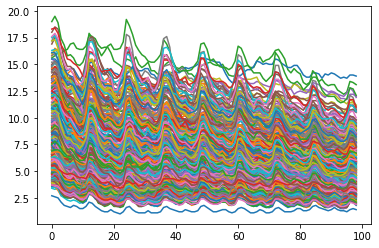

In [55]:
df_y_grouped = df.groupby('ags5')
for group, group_df in df_y_grouped:
    new_series = group_df.sort_values('date').reset_index(drop=True).drop(['date'], axis=1).copy()
    plt.plot(new_series)
plt.show()

In [297]:
df_y_grouped

In [298]:
X

['purchasing_power_per_household',
 'debtor_quota',
 'Number_of_Commuters_on_place_of_residence)']

In [299]:
series = list(df_y_grouped.get_group(1004).sort_values('date').drop(['date'], axis=1).copy()['unemployment_rate'])
plt.plot(series)
plt.show()

KeyError: 1004

### DATA IS VERY VERY SEASONAL!!!!!!!!!!!!!!!!!!!!!!!

## Exog variables

In [22]:
X = pd.read_csv('./../../../final_dfs/for_modeling/df_final_date_wide_2007.csv', converters={'ags2': str, 'ags5': str} )
# fix ags5 missing 0 
X['ags5'] = np.where(X.ags5.str.len() ==4, '0' + X['ags5'], X['ags5'])
X['date'] = pd.to_datetime(X['date'], format = '%Y-%m-%d')
#shift date by 3 months
X['date'] = X.groupby(['ags5'])['date'].shift(-3)
X.set_index(X['ags5'], drop=True, inplace=True)
X = X[['date','number_of_company_deletions','number_of_company_liquidations','number_of_start_ups','employees_social_security_at_residence','employees_social_security_at_work','registerd_jobs']]
X = X[(X['date'] >= '2007-05-01') & (X['date'] < '2021-08-01')]
#X = X[(X['date'] >= '2010-01-01') & (X['date'] < '2018-04-01')]
#X = X.groupby('ags5')
X

,date,number_of_company_deletions,number_of_company_liquidations,number_of_start_ups,employees_social_security_at_residence,employees_social_security_at_work,registerd_jobs
ags5,,,,,,,
01001,2007-05-01,5.0,3.0,12.0,NaN,NaN,NaN
01001,2007-06-01,7.0,6.0,19.0,NaN,NaN,NaN
01001,2007-07-01,5.0,1.0,11.0,NaN,NaN,NaN
01001,2007-08-01,4.0,2.0,21.0,NaN,NaN,NaN
01001,2007-09-01,8.0,6.0,18.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
16077,2021-01-01,0.0,0.0,7.0,NaN,NaN,774.0
16077,2021-02-01,3.0,1.0,5.0,NaN,NaN,695.0
16077,2021-03-01,2.0,1.0,6.0,NaN,NaN,702.0


# 401 Model for each kreis

In [23]:
# one-step sarima forecast
def sarima_forecast(history, X_train, X_test, n_test, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, 
                    exog = X_train,
                    order=order, 
                    seasonal_order=sorder, 
                    trend=trend, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history) + n_test -1, exog = X_test)
    return yhat

In [24]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [25]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [26]:
#validation for univariate data
def validation(data, X_data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    X_train, X_test = train_test_split(X_data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    X_train = [x for x in X_train]
    X_test = [x for x in X_test]
     # fit model and make forecast for history
    predictions = sarima_forecast(history, X_train, X_test, n_test, cfg)

    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

In [27]:
# score a model, return None on failure
def score_model(data, X_data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = validation(data, X_data, n_test, cfg)
    else:
            # one failure during model validation suggests an unstable config
        if True:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = validation(data, X_data, n_test, cfg)
        #except:
        #    error = None
    # check for an interesting result
#     if result is not None:
#         print(' > Model[%s] %.3f' % (key, result))
        
    print('.', end='')
    return (key, result)

----------
!mlflow experiments create --experiment-name 401ModelsNoWalkForward

Created experiment '401ModelsNoWalkForward' with id 7

---------

In [57]:
# data split
n_test = 3
# model config
cfg = [(1, 1, 1), (1, 0, 1, 3), None]
# train 401 models
print("Training", end=' ')
failed_ags5 = []
rmse_scores = []

with mlflow.start_run():
    
    for ags5, df_for_kreis in df_y_grouped:
        data = list(df_for_kreis.sort_values('date').drop(['date'], axis=1).copy()['unemployment_rate'])
        X_for_kreis = X.get_group(ags5)
        X_data = np.array(X_for_kreis.sort_values('date').drop(['date'], axis=1).copy())
        #try: 
        if True:
            score = score_model(data, X_data, n_test, cfg)

            if score is None:
                raise Exception("No Score")
            
            rmse_scores.append(score[1])
            print('.', end='')
        #except:
        #    failed_ags5.append(ags5)
        #    print('!', end='')
            
    params = {}
    params['p'], params['d'], params['q'] = cfg[0]
    params['s_p'], params['s_d'], params['s_q'], params['m'] = cfg[1]
    params['t'] = cfg[2]
    
    net_rmse = np.mean([rmse**2 for rmse in rmse_scores])**(0.5)
    
    
    mlflow.log_params(params)
    mlflow.log_metric('net_rmse', net_rmse)
      
    

print('\ndone')
print("Failed ags5:", failed_ags5)

Training ..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
done
Failed ags5: []


In [15]:
net_rmse

0.2824869994750325

In [353]:
for ags5, df_for_kreis in df_y_grouped:
    print(list(df_for_kreis.sort_values('date').drop(['date'], axis=1).copy()))


['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemployment_rate']
['unemploy

In [357]:
for ags5, df_for_kreis in df_y_grouped:
       print(list(X_for_kreis.sort_values('date').drop(['date'], axis=1).copy()['debtor_quota']))


[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

In [210]:
history

AttributeError: 'list' object has no attribute 'values'

In [215]:
train

,date,unemployment_rate
ags5,,
01001,2010-01-31,13.7
01001,2010-02-28,14.1
01001,2010-03-31,13.6
01001,2010-04-30,13.1
01001,2010-05-31,12.5
...,...,...
16077,2018-08-31,7.4
16077,2018-09-30,7.3
16077,2018-10-31,7.3


In [329]:
    for ags5, df_for_kreis in df_y_grouped:
            print(df_for_kreis)

            date  unemployment_rate
ags5                               
01001 2010-01-31               13.7
01001 2010-02-28               14.1
01001 2010-03-31               13.6
01001 2010-04-30               13.1
01001 2010-05-31               12.5
...          ...                ...
01001 2019-08-31                8.3
01001 2019-09-30                8.3
01001 2019-10-31                8.1
01001 2019-11-30                8.0
01001 2019-12-31                7.9

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
01002 2010-01-31               11.2
01002 2010-02-28               11.1
01002 2010-03-31               10.9
01002 2010-04-30               11.0
01002 2010-05-31               10.6
...          ...                ...
01002 2019-08-31                7.8
01002 2019-09-30                7.4
01002 2019-10-31                7.4
01002 2019-11-30                7.2
01002 2019-12-31                7.2

[120 rows x 2 columns]
            date

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
05122 2010-01-31                9.1
05122 2010-02-28                9.2
05122 2010-03-31                9.3
05122 2010-04-30                9.2
05122 2010-05-31                9.1
...          ...                ...
05122 2019-08-31                7.1
05122 2019-09-30                6.9
05122 2019-10-31                6.9
05122 2019-11-30                6.7
05122 2019-12-31                6.8

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
05124 2010-01-31               12.0
05124 2010-02-28               12.2
05124 2010-03-31               12.1
05124 2010-04-30               12.0
05124 2010-05-31               11.7
...          ...                ...
05124 2019-08-31                8.4
05124 2019-09-30                8.1
05124 2019-10-31                8.0
05124 2019-11-30                8.0
05124 2019-12-31                8.0

[120 rows x 2 co

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
06632 2010-01-31                7.2
06632 2010-02-28                7.3
06632 2010-03-31                7.3
06632 2010-04-30                6.8
06632 2010-05-31                6.3
...          ...                ...
06632 2019-08-31                3.7
06632 2019-09-30                3.5
06632 2019-10-31                3.4
06632 2019-11-30                3.3
06632 2019-12-31                3.2

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
06633 2010-01-31                6.0
06633 2010-02-28                6.1
06633 2010-03-31                5.9
06633 2010-04-30                5.6
06633 2010-05-31                5.2
...          ...                ...
06633 2019-08-31                3.5
06633 2019-09-30                3.4
06633 2019-10-31                3.5
06633 2019-11-30                3.4
06633 2019-12-31                3.6

[120 rows x 2 co

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
08327 2010-01-31                5.4
08327 2010-02-28                5.5
08327 2010-03-31                5.4
08327 2010-04-30                5.1
08327 2010-05-31                5.0
...          ...                ...
08327 2019-08-31                2.9
08327 2019-09-30                2.8
08327 2019-10-31                2.8
08327 2019-11-30                2.8
08327 2019-12-31                3.0

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
08335 2010-01-31                6.1
08335 2010-02-28                6.1
08335 2010-03-31                5.8
08335 2010-04-30                5.6
08335 2010-05-31                5.4
...          ...                ...
08335 2019-08-31                3.3
08335 2019-09-30                3.1
08335 2019-10-31                3.0
08335 2019-11-30                3.0
08335 2019-12-31                3.2

[120 rows x 2 co

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
09564 2010-01-31                9.1
09564 2010-02-28                9.0
09564 2010-03-31                8.9
09564 2010-04-30                8.8
09564 2010-05-31                8.4
...          ...                ...
09564 2019-08-31                5.4
09564 2019-09-30                5.2
09564 2019-10-31                5.0
09564 2019-11-30                4.8
09564 2019-12-31                4.9

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
09565 2010-01-31                6.0
09565 2010-02-28                6.1
09565 2010-03-31                6.0
09565 2010-04-30                5.7
09565 2010-05-31                5.2
...          ...                ...
09565 2019-08-31                3.4
09565 2019-09-30                3.2
09565 2019-10-31                3.0
09565 2019-11-30                3.0
09565 2019-12-31                3.2

[120 rows x 2 co

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
13072 2010-01-31               13.7
13072 2010-02-28               13.9
13072 2010-03-31               13.5
13072 2010-04-30               11.7
13072 2010-05-31               10.5
...          ...                ...
13072 2019-08-31                5.0
13072 2019-09-30                4.8
13072 2019-10-31                4.7
13072 2019-11-30                4.9
13072 2019-12-31                5.1

[120 rows x 2 columns]
            date  unemployment_rate
ags5                               
13073 2010-01-31               17.2
13073 2010-02-28               17.8
13073 2010-03-31               17.2
13073 2010-04-30               14.5
13073 2010-05-31               12.6
...          ...                ...
13073 2019-08-31                6.9
13073 2019-09-30                6.7
13073 2019-10-31                6.9
13073 2019-11-30                7.7
13073 2019-12-31                8.8

[120 rows x 2 co

In [252]:
X_train.shape

(48108, 4)

KeyError: 'Column not found: ags5'

In [257]:
n_test = 12

train = list(df.sort_values('date').drop(['date'], axis=1).copy())
history = [x for x in train]

X = list(X.sort_values('date').drop(['date'], axis=1).copy())
X_train, X_test = train_test_split(X, n_test)
X_train = [x for x in X_train]

# define model
model = SARIMAX(history, 
                exog = X_train)

['unemployment_rate']


AttributeError: 'list' object has no attribute 'sort_values'

In [272]:
X

,date,purchasing_power_per_household,debtor_quota,Number_of_Commuters_on_place_of_residence)
ags5,,,,
01001,2010-01-31,34496.0,16.0,11096.0
01001,2010-02-28,34496.0,16.0,11096.0
01001,2010-03-31,34496.0,16.0,11096.0
01001,2010-04-30,34496.0,16.0,11096.0
01001,2010-05-31,34496.0,16.0,11096.0
...,...,...,...,...
16077,2019-08-31,38560.0,9.0,13135.0
16077,2019-09-30,38560.0,9.0,13135.0
16077,2019-10-31,38560.0,9.0,13135.0


In [285]:
for ags5, df_for_kreis in df_y_grouped:
    df_y_grouped.get_group(ags5)